In [4]:
import mlflow
mlflow.set_tracking_uri("http://ec2-3-82-21-172.compute-1.amazonaws.com:5000/")

with mlflow.start_run():
    mlflow.log_param("param1", 15)
    mlflow.log_metric("metric1", 0.89)

Exception: Run with UUID bb76269ba17d443a8200e0a81a96725a is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()
     

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [3]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df = df[~(df['clean_comment'].str.strip() == '')]

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Uddhav
[nltk_data]     Sen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Uddhav
[nltk_data]     Sen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
def preprocess_comment(comment):
    comment = comment.lower()
    comment = comment.strip()
    comment = re.sub(r'\n', ' ', comment)
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [7]:
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)

In [8]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
vectorizer = CountVectorizer(max_features=10000)

In [10]:
X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category']

In [11]:
X.shape

(36793, 10000)

In [12]:
y

0        1
1        1
2       -1
3        0
4        1
        ..
37244    0
37245    1
37246    0
37247    1
37248    0
Name: category, Length: 36793, dtype: int64

In [13]:
y.shape

(36793,)

In [14]:
mlflow.set_tracking_uri("http://ec2-3-82-21-172.compute-1.amazonaws.com:5000/")

In [15]:
mlflow.set_experiment("RF Baseline")

<Experiment: artifact_location='s3://mlflowexperiment-26/1', creation_time=1767596644018, experiment_id='1', last_update_time=1767596644018, lifecycle_stage='active', name='RF Baseline', tags={'mlflow.experimentKind': 'custom_model_development'}>

2026/01/05 18:07:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run RandomForest_Baseline_TrainTestSplit at: http://ec2-3-82-21-172.compute-1.amazonaws.com:5000/#/experiments/1/runs/cbe648318b24438ea1300b08391c0b09
🧪 View experiment at: http://ec2-3-82-21-172.compute-1.amazonaws.com:5000/#/experiments/1
Accuracy: 0.6479141187661367


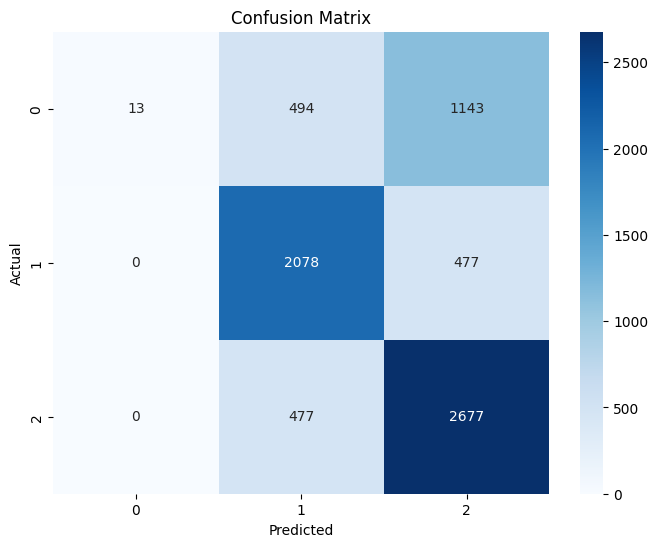

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

with mlflow.start_run() as run:
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    mlflow.sklearn.log_model(model, "random_forest_model")

    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("dataset.csv")

print(f"Accuracy: {accuracy}")
     

In [17]:
print(classification_report(y_test, y_pred))
df.to_csv('reddit_preprocessing.csv', index=False)

              precision    recall  f1-score   support

          -1       1.00      0.01      0.02      1650
           0       0.68      0.81      0.74      2555
           1       0.62      0.85      0.72      3154

    accuracy                           0.65      7359
   macro avg       0.77      0.56      0.49      7359
weighted avg       0.73      0.65      0.57      7359

